# Assignment 04

**Citation:** The following questions and supporting code were originally developed as part of Dr. Eric Eaton's [Introduction to Machine Learning Course at U Penn](https://www.cis.upenn.edu/~cis5190/fall2014/). 



**DO NOT USE PyTorch's automatic differentiation capabilities to solve this problem**

In [1]:
from typing import Optional, Tuple, List, Dict

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from utils import load_dataset

# When choosing your batches / Shuffling your data you should use this RNG variable, and not `np.random.choice` etc.
RNG = np.random.RandomState(seed=446)

def load_2_7_mnist():
    """
    Loads MNIST data, extracts only examples with 2, 7 as labels, and converts them into -1, 1 labels, respectively.

    Returns:
        Dataset: 2 tuples of numpy arrays, each containing examples and labels.
            First tuple is for training, while second is for testing.
            Shapes as as follows: ((n, d), (n,)), ((m, d), (m,))
    """
    (x_train, y_train), (x_test, y_test) = load_dataset("mnist")
    train_idxs = np.logical_or(y_train == 2, y_train == 7)
    test_idxs = np.logical_or(y_test == 2, y_test == 7)

    y_train_2_7 = y_train[train_idxs]
    y_train_2_7 = np.where(y_train_2_7 == 7, 1, -1)

    y_test_2_7 = y_test[test_idxs]
    y_test_2_7 = np.where(y_test_2_7 == 7, 1, -1)

    return (x_train[train_idxs], y_train_2_7), (x_test[test_idxs], y_test_2_7)

# Stochastic Gradient Descent -- Logistic Regression

**2.1** Here we consider the MNIST dataset, but for binary classification. Specifically, the task is to determine whether a digit is a 2 or 7. Here, let $Y = 1$ for all the “7” digits in the dataset, and use $Y = −1$ for “2”. We will use regularized logistic regression. Given a binary classification dataset $\{(x_i, y_i)\}^{n}_{i=1}$ for $x_i \in \mathbb{R}^{d}$ and $y_i \in \{−1, 1\}$ we showed in class that the regularized negative log likelihood objective function can be written as

$$
J(w, b) = \frac{1}{n}\sum_{i=1}^{m}\log(1 + exp(−y_i (b + x^{T}_i w))) + \lambda\|w\|^{2}_{2}
$$

Note that the offset term $b$ is not regularized. For all experiments, use $\lambda = 10^{−1}$. Let $\mu_i(w, b) = \frac{1}{1+exp(−y_{i} (b+x_{i}^{T} w))}$.
    
**a.** [8 points] Derive the gradients $\nabla_{w} J(w, b)$, $\nabla_{b} J(w, b)$ and give your answers in terms of $\mu_i(w, b)$ (your answers should not contain exponentials).



**Your answer here:**
 
$$
$$

**b.** [8 points] Implement gradient descent with an initial iterate of all zeros. Try several values of step sizes to find one that appears to make convergence on the training set as fast as possible. Run until you feel you are near to convergence.  

i. For both the training set and the test, plot $J(w, b)$ as a function of the iteration number (and show both curves on the same plot).  
ii. For both the training set and the test, classify the points according to the rule $\mathrm{sign}(b + x^{T}_{i}w)$ and plot the misclassification error as a function of the iteration number (and show both curves on the same plot).
    
**Reminder:** Make sure you are only using the test set for evaluation (not for training).



In [2]:
class BinaryLogReg:
    def __init__(self, _lambda: float = 1e-3):
        """Initializes the Binary Log Regression model.
        NOTE: Please DO NOT change `self.weight` and `self.bias` values, since it may break testing and lead to lost points!

        Args:
            _lambda (float, optional): Ridge Regularization coefficient. Defaults to 1e-3.
        """
        self._lambda: float = _lambda
        # Fill in with matrix with the correct shape
        self.weight: np.ndarray = None  # type: ignore
        self.bias: float = 0.0

    def mu(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Calculate mu in vectorized form, as described in the problem.
        The equation for i^th element of vector mu is given by:

        $$ \mu_i = 1 / (1 + \exp(-y_i (bias + x_i^T weight))) $$

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            np.ndarray: An `(n, )` vector containing mu_i for i^th element.
        """
        weighted_sum = np.dot(X, self.weight) + self.bias  # (n, d) @ (d, ) + scalar --> (n, )
        mu = 1 / (1 + np.exp(-y * weighted_sum))    # (n, ) * (n, ) --> (n, )
        return mu        

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate loss J as defined in the problem.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: Loss given X, y, self.weight, self.bias and self._lambda
        """
        mu_value = self.mu(X, y)
        error = np.mean(-np.log(mu_value))
        reg = self._lambda * np.sum(self.weight ** 2)
        return error + reg

    def gradient_J_weight(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Calculate gradient of loss J with respect to weight.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.
        Returns:
            np.ndarray: An `(d, )` vector which represents gradient of loss J with respect to self.weight.
        """
        # From part a): \nabla_{w} J(w, b) = -\frac{1}{m}\sum_{i=1}^{m} y_i x_i (1 - \mu_i(w, b)) + 2 \lambda w
        mu_value = self.mu(X, y)
        grad_w_error = -np.mean(y[:, np.newaxis] * X * (1 - mu_value)[:, np.newaxis], axis=0)  # (n, ) * (n, d) * (n, ) --> (n, d), mean across n --> (d, )
        grad_w_reg = 2 * self._lambda * self.weight # (d,)
        return grad_w_error + grad_w_reg

    def gradient_J_bias(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate gradient of loss J with respect to bias.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: A number that represents gradient of loss J with respect to self.bias.
        """
        # From part a): \nabla_{b} J(w, b) = -\frac{1}{m}\sum_{i=1}^{m} y_i (1 - \mu_i(w, b))
        mu_value = self.mu(X, y)
        grad_b = -np.mean(y * (1 - mu_value))  # (n, ) * (n, ) --> (n, ), mean across n --> scalar
        return grad_b

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Given X, weight and bias predict values of y.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.

        Returns:
            np.ndarray: An `(n, )` array of either -1s or 1s representing guess for each observation.
        """
        weighted_sum = np.dot(X, self.weight) + self.bias
        return np.where(weighted_sum > 0, 1, -1) # Y in {-1, 1}

    def misclassification_error(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculates misclassification error (the rate at which this model is making incorrect predictions of y).
        Note that `misclassification_error = 1 - accuracy`.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: percentage of times prediction did not match target, given an observation (i.e. misclassification error).
        """
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return 1 - accuracy

    def step(self, X: np.ndarray, y: np.ndarray, learning_rate: float = 1e-4):
        """Single step in training loop.
        It does not return anything but should update self.weight and self.bias with correct values.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.
            learning_rate (float, optional): Learning rate of SGD/GD algorithm.
                Defaults to 1e-4.
        """
        # Apply the gradients to the weights and bias
        grad_w = self.gradient_J_weight(X, y)
        grad_b = self.gradient_J_bias(X, y)
        self.weight -= learning_rate * grad_w
        self.bias -= learning_rate * grad_b

    def train(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        learning_rate: float = 1e-2,
        epochs: int = 30,
        batch_size: int = 100,
    ) -> Dict[str, List[float]]:
        """Train function that given dataset X_train and y_train adjusts weights and biases of this model.
        It also should calculate misclassification error and J loss at the END of each epoch.

        For each epoch please call step function `num_batches` times as defined on top of the starter code.

        NOTE: This function due to complexity and number of possible implementations will not be publicly unit tested.
        However, we might still test it using gradescope, and you will be graded based on the plots that are generated using this function.

        Args:
            X_train (np.ndarray): observations in training set represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y_train (np.ndarray): targets in training set represented as `(n, )` vector.
                n is number of observations.
            X_test (np.ndarray): observations in testing set represented as `(m, d)` matrix.
                m is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y_test (np.ndarray): targets in testing set represented as `(m, )` vector.
                m is number of observations.
            learning_rate (float, optional): Learning rate of SGD/GD algorithm. Defaults to 1e-2.
            epochs (int, optional): Number of epochs (loops through the whole data) to train SGD/GD algorithm for.
                Defaults to 30.
            batch_size (int, optional): Number of observation/target pairs to use for a single update.
                Defaults to 100.

        Returns:
            Dict[str, List[float]]: Dictionary containing 4 keys, each pointing to a list/numpy array of length `epochs`:
            {
                "training_losses": [<Loss at the end of each epoch on training set>],
                "training_errors": [<Misclassification error at the end of each epoch on training set>],
                "testing_losses": [<Same as above but for testing set>],
                "testing_errors": [<Same as above but for testing set>],
            }
            Skeleton for this result is provided in the starter code.

        Note:
            - When shuffling batches/randomly choosing batches makes sure you are using RNG variable defined on the top of the file.
        """
        if batch_size is not None:
            num_batches = int(np.ceil(len(X_train) // batch_size))
            
        result: Dict[str, List[float]] = {
            "train_losses": [],  # You should append to these lists
            "train_errors": [],
            "test_losses": [],
            "test_errors": [],
        }

        # Reset weights and biases
        self.weight = np.zeros(X_train.shape[1])
        self.bias = 0.0

        for epoch in range(epochs):
            # Use RNG to shuffle the dataset so batches are different between epochs
            idxs = RNG.permutation(len(X_train))
            X_train = X_train[idxs]
            y_train = y_train[idxs]

            # SGD: update on one batch at a time
            if batch_size is not None:
                for i in range(num_batches):
                    # Calculate the start and end indices for each batch
                    start_idx = i * batch_size
                    end_idx = min((i + 1) * batch_size, len(X_train))

                    # Only use the training set to update the model
                    self.step(X_train[start_idx:end_idx], y_train[start_idx:end_idx], learning_rate)
            
            # GD: Update on the whole dataset, not batches
            else:
                self.step(X_train, y_train, learning_rate)

            # Calculate and store the losses and errors
            result["train_losses"].append(self.loss(X_train, y_train))
            result["train_errors"].append(self.misclassification_error(X_train, y_train))
            result["test_losses"].append(self.loss(X_test, y_test))
            result["test_errors"].append(self.misclassification_error(X_test, y_test))

        return result

In [3]:
def plot_training_results(batch_size=None, learning_rate=None):
    model = BinaryLogReg()
    (x_train, y_train), (x_test, y_test) = load_2_7_mnist()

    if learning_rate is None:
        # Find the best learning rate using the average of the last 5 epochs
        learning_rates = np.logspace(-4, 1, 20)
        train_errors = []
        test_errors = []
        for lr in tqdm(learning_rates):
            history = model.train(x_train, y_train, x_test, y_test, learning_rate=lr, batch_size=batch_size)
            train_errors.append(np.mean(history["train_errors"][-5:]))
            test_errors.append(np.mean(history["test_errors"][-5:]))
            
        learning_rate = learning_rates[np.argmin(test_errors)]
        print("Best learning rate:", learning_rate)

        plt.plot(learning_rates, train_errors, label="Train")
        plt.plot(learning_rates, test_errors, label="Test")
        plt.xscale("log")
        plt.xlabel("Learning Rate")
        plt.ylabel("Misclassification Error")
        plt.title("Learning Rate vs Misclassification Error After 30 Epochs")
        plt.legend()
        plt.show()

    # Train the model using the chosen learning rate
    history = model.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size)

    # Plot losses
    plt.plot(history["train_losses"], label="Train")
    plt.plot(history["test_losses"], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Losses")
    plt.legend()
    plt.show()

    # Plot error
    plt.plot(history["train_errors"], label="Train")
    plt.plot(history["test_errors"], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Misclassification Error")
    plt.title("Train and Test Errors")
    plt.legend()
    plt.show()

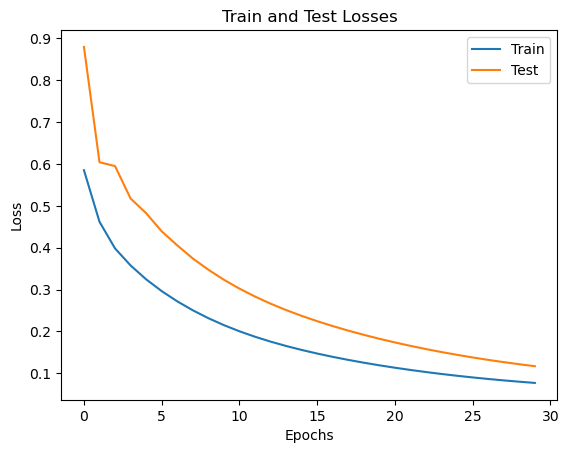

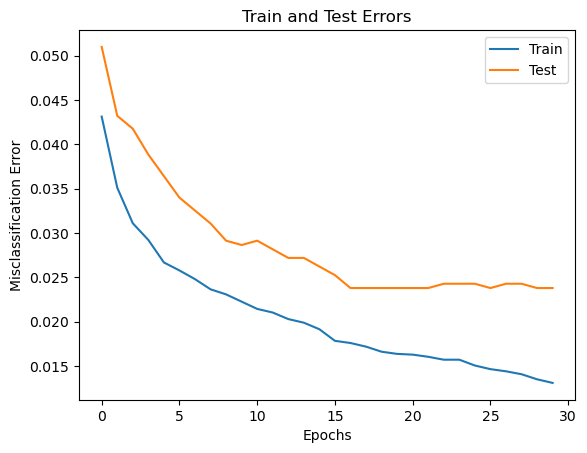

In [4]:
# Gradient descent: use the whole dataset per epoch (no batch size)
plot_training_results(batch_size=None, learning_rate=10.0)

**c.** [7 points] Repeat (b) using stochastic gradient descent with a batch size of 1. Note, the expected gradient
with respect to the random selection should be equal to the gradient found in part (a). Show both plots
described in (b) when using batch size 1. Take careful note of how to scale the regularizer.

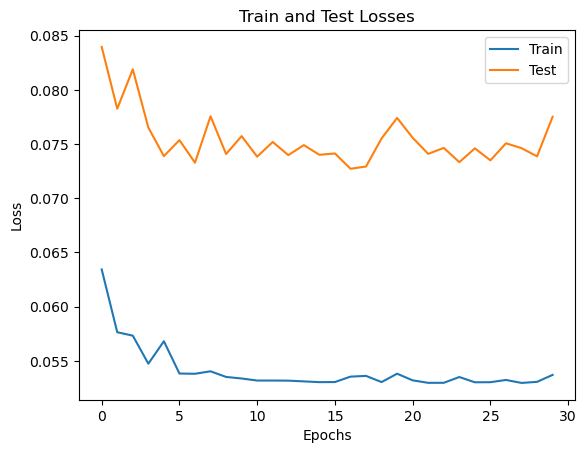

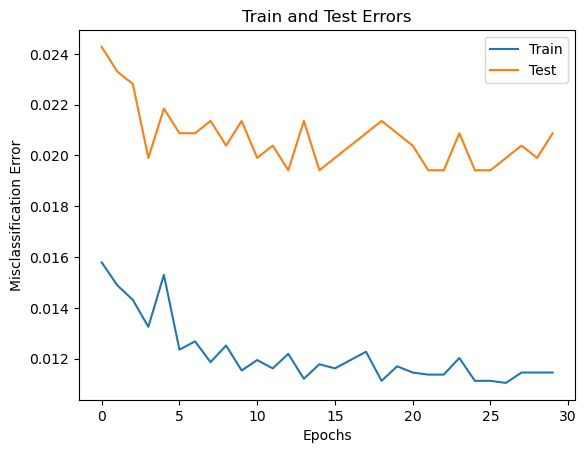

In [5]:
# Use a batch size of 1 (SGD)
plot_training_results(batch_size=1, learning_rate=0.00379269019073225)

**d.** [7 points] Repeat (b) using stochastic gradient descent with batch size of 100. That is, instead of approximating the gradient with a single example, use 100. Note, the expected gradient with respect to the
random selection should be equal to the gradient found in part (a).

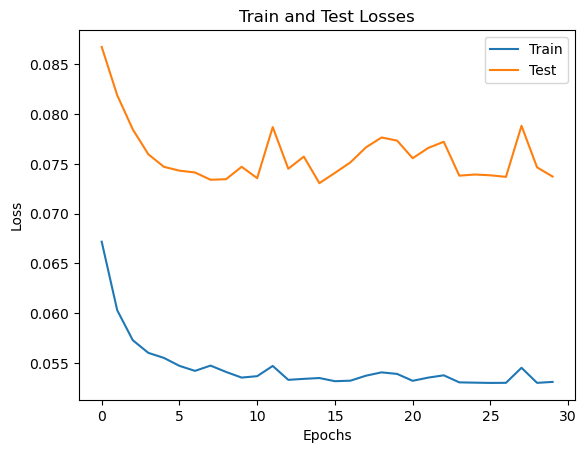

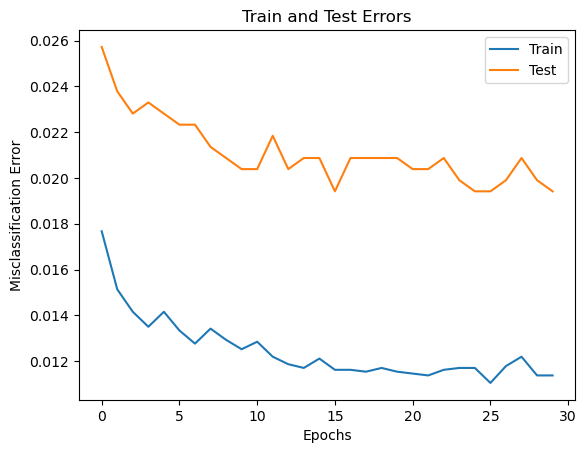

In [6]:
# Use a batch size of 100 (SGD)
plot_training_results(batch_size=100, learning_rate=0.26366508987303583)

**What to Submit**
- **Part a:** Proof
- **Part b:** Separate plots for b(i) and b(ii).
- **Part c:** Separate plots for c which reproduce those from b(i) and b(ii) for this case.
- **Part d:** Separate plots for d which reproduce those from b(i) and b(ii) for this case.

# Support Vector Machines

**2.2** Recall that solving the SVM problem amounts to solving the following constrained optimization problem:

Given data points $\mathcal{D} = \{(x_i , y_i )\}^{n}_{i=1}$ find  $\min_{w,b} \|w\|_{2}$ subject to $y_i(x^{T}_{i}w + b) \geq 1$ for $i \in \{1, \ldots , n\}$  where $x_i \in \mathbb{R}^{d}$ , $y_i \in \{−1, 1\}$, and $w \in \mathbb{R}^{d}$.

Consider the following labeled data points:


$$
\begin{bmatrix}
1 & 2\\
1 & 3\\
2 & 3\\
3 & 4
\end{bmatrix} \text{ with label } y = -1 \text{ and } \begin{bmatrix}
0 & 0.5\\
1 & 0\\
2 & 1\\
3 & 0
\end{bmatrix} \text{ with label } y = 1
$$

**a.** [2 points] Graph the data points above. Highlight the support vectors and write their coordinates. Draw
the two parallel hyperplanes separating the two classes of data such that the distance between them is
as large as possible. Draw the maximum-margin hyperplane. Write the equations describing these three
hyperplanes using only x, w, b(that is without using any specific values). Draw w(it doesn’t have to have
the exact magnitude, but it should have the correct orientation).

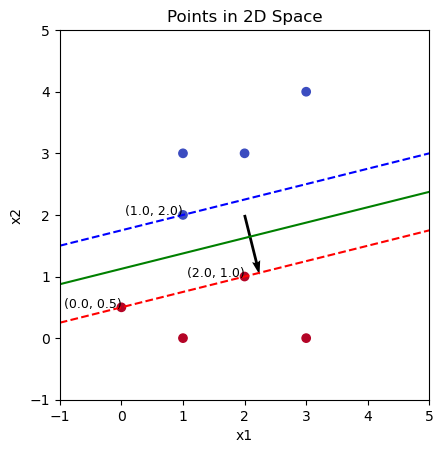

In [7]:
def Q2a():
    # Define the points
    X = np.array([[1, 2], [1, 3], [2, 3], [3, 4], [0, 0.5], [1, 0], [2, 1], [3, 0]])
    y = np.array([-1, -1, -1, -1, 1, 1, 1, 1])

    # Highlight the support vectors and write their coordinates
    sv_idxs = [0, 4, 6]
    for sv in sv_idxs:
        plt.text(X[sv, 0], X[sv, 1], f'({X[sv, 0]}, {X[sv, 1]})', fontsize=9, ha='right')

    # Calculate and graph the hyperplane that rests on 2 points
    slope = (1 - 0.5) / (2 - 0)
    intercept_1 = 1 - slope * 2
    x_vals = np.linspace(-1, 5, 100)
    y_vals = slope * x_vals + intercept_1
    plt.plot(x_vals, y_vals, 'r--')

    # Calculate the other line that rests on only 1 point
    intercept_2 = 2 - slope * 1
    y_vals_2 = slope * x_vals + intercept_2
    plt.plot(x_vals, y_vals_2, 'b--')

    # Plot the maximum-margin hyperplane
    intercept_3 = (intercept_1 + intercept_2) / 2
    y_vals_3 = slope * x_vals + intercept_3
    plt.plot(x_vals, y_vals_3, 'g-')

    # Draw weight vector w, which is normal to the hyperplane
    w = np.array([slope, -1])
    w_norm = np.linalg.norm(w)
    w = w / w_norm
    plt.quiver(2, 2, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='black')
        
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Points in 2D Space')
    plt.xlim(-1, 5)
    plt.ylim(-1, 5)
    plt.gca().set_aspect("equal")
    plt.show()

Q2a()

**b.** [2 points] For the data points above, find w and b.

**Hint:** Use the support vectors and the values {−1, 1} to create a linear system of equations where the
unknowns are w1 , w2 and b.

In [8]:
def Q2b():
    # Create a linear system of equations
    a = np.array([[1, 2, 1], [2, 1, 1], [0, 0.5, 1]])
    b = np.array([-1, 1, 1])
    x = np.linalg.solve(a, b)
    print(x)

Q2b()

[ 0.4 -1.6  1.8]


**What to Submit:**
- **Part a:** Write down support vectors and equations. Graph the points, hyperplanes, and w.
- **Part b:** Solution and corresponding calculations.

# Kernels

**2.3** Suppose that our inputs x are one-dimensional and that our feature map is infinite-dimensional:
$\phi(x)$ is a vector whose ith component is:

$$
    \frac{1}{\sqrt{i!}}\exp\left(-\frac{x^{2}}{2}\right)x^{i},
$$

for all nonnegative integers $i$. (Thus, $\phi$ is an infinite-dimensional vector.)

**a.** [2 points] Show that $k(x, x′) = \exp\left(−\frac{(x-x')^{2}}{2}\right)$ is a kernel function for this feature map, i.e.,

$$
\phi(x)\cdot\phi(x') = \exp\left(−\frac{(x-x')^{2}}{2}\right)
$$

**Hint:** Use the Taylor expansion of $z \mapsto \exp(-z)$. (This is the one dimensional version of the Gaussian (RBF) kernel).

**your answer here**

$$
$$

**b.** [5 points] Plot $x$ vs $\exp\left(−\frac{x^{2}}{2}\right)$, and $x$ vs $\phi(x)\cdot\phi(0)$ for $10, 100, 500$ dimensions over the range $x \in [-5,5]$. on the same graph.

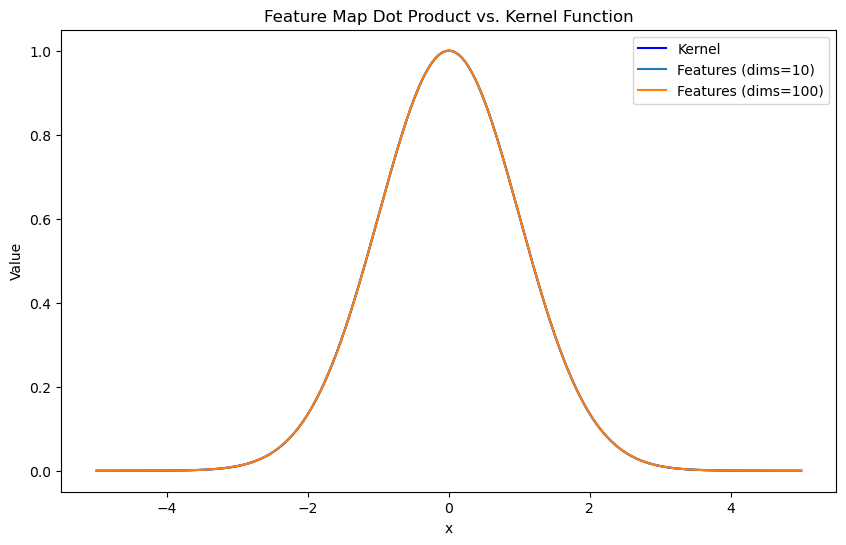

In [9]:
### your answer here
import math

def Q3b():
    def feature_product(x1, x2, dims):
        sum = 0
        for i in range(dims):
            phi1 = np.exp(-x1**2 / 2) * x1**i / np.sqrt(float(math.factorial(i)))
            phi2 = np.exp(-x2**2 / 2) * x2**i / np.sqrt(float(math.factorial(i)))
            sum += phi1 * phi2
        return sum

    # For 10, 100, and 500 dimensions over the range x in [-5, 5]
    dimensions = [10, 100]  # 500 is too large for factorial
    x = np.linspace(-5, 5, 1000)

    # Plot x vs. exp(-x^2 / 2) --> Kernel function
    plt.figure(figsize=(10, 6))
    plt.plot(x, np.exp(-x**2 / 2), label='Kernel', color='blue')

    # Plot x vs. phi(x) dot phi(0) --> Feature map dot product
    for dims in dimensions:
        y = np.array([feature_product(xi, 0, dims) for xi in x])
        plt.plot(x, y, label=f'Features (dims={dims})')

    plt.title('Feature Map Dot Product vs. Kernel Function')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Q3b()

**What to Submit:**
- **Part a:** Solution and corresponding calculations
- **Part b:** Graph and 1-2 sentences on your observations.

**2.4** This problem will get you familiar with kernel ridge regression using the polynomial and RBF kernels.
First, let’s generate some data. Let $n = 30$ and $f_{∗}(x) = 4 \sin(\pi x) \cos(6\pi x^{2} )$. For $i = 1, \ldots, n$ let each $x_i$ be drawn uniformly at random from $[0, 1]$, and let $y_i = f_{∗}(x_i) + \epsilon_i$ where $\epsilon_i \sim \mathcal{N}(0, 1)$. For any function $f$, the true error and the train error are respectively defined as:

$$
\mathcal{E}_\mathrm{true}(f) = \mathbb{E}_{X,Y}[(f(X)-Y)^{2}], \hat{\mathcal{E}}_\mathrm{train}(f) = \frac{1}{n}\sum_{i=1}^{n} (f(x_{i})- y_{i})^2.
$$

Now, our goal is, using kernel ridge regression, to construct a predictor:

$$
\hat{\alpha} = \arg\min_{\alpha} \|K\alpha - y \|^{2}_{2} + \lambda \alpha^{T}K\alpha, \hat{f}(x) = \sum_{i=1}^{n}\hat{\alpha}_{i}k(x_i,x)
$$

where $K \in \mathbb{R}^{n \times n}$ is the kernel matrix such that $K_{i,j} = k(x_i,x_j)$, and $\lambda \geq 0$ is the regularization constant.

In [10]:
def f_true(x: np.ndarray) -> np.ndarray:
    """True function, which was used to generate data.
    Should be used for plotting.

    Args:
        x (np.ndarray): A (n,) array. Input.

    Returns:
        np.ndarray: A (n,) array.
    """
    return 4 * np.sin(np.pi * x) * np.cos(6 * np.pi * x ** 2)


**a.** [10 points] Using leave-one-out cross validation, find a good $\lambda$ and hyperparameter settings for the following kernels:
- $k_\mathrm{poly}(x, z) = (1 + x^{⊤}z)^{d}$ where $d \in \mathbb{N}$ is a hyperparameter
- $k_\mathrm{rbf}(x, z) = \exp\left(−\gamma\|x − z\|^{2} \right)$ where $\gamma > 0$ is a hyperparameter 1

We strongly recommend implementing either grid search or random search. **Do not use ```sklearn```**, but
actually implement of these algorithms. Reasonable values to look through in this problem are: $\lambda \in  10^{[−5,−1] }$, $d \in [5, 25]$, $\gamma$ sampled from a narrow gaussian distribution centered the median of all squared distances in the dataset, *i.e.*: Given a dataset $x_{1}, \ldots, x_{n} \in \mathrm{R}^{d}$, a heuristic for choosing a range of $\gamma$ in the right ballpark is the inverse of the median of all $\begin{pmatrix}n \\ 2 \end{pmatrix}$ squared distances $\|x_i − x_j \|_{2}^{2}$.

Report the values of $d$, $\gamma$, and the $\lambda$ values for both kernels.

In [11]:
def poly_kernel(x_i: np.ndarray, x_j: np.ndarray, d: int) -> np.ndarray:
    """Polynomial kernel.

    Given two indices a and b it should calculate:
    K[a, b] = (x_i[a] * x_j[b] + 1)^d

    Args:
        x_i (np.ndarray): An (n,) array. Observations (Might be different from x_j).
        x_j (np.ndarray): An (m,) array. Observations (Might be different from x_i).
        d (int): Degree of polynomial.

    Returns:
        np.ndarray: A (n, m) matrix, where each element is as described above (see equation for K[a, b])

    Note:
        - It is crucial for this function to be vectorized, and not contain for-loops.
            It will be called a lot, and it has to be fast for reasonable run-time.
        - You might find .outer functions useful for this function.
            They apply an operation similar to xx^T (if x is a vector), but not necessarily with multiplication.
            To use it simply append .outer to function. For example: np.add.outer, np.divide.outer
    """
    product = 1 + np.multiply.outer(x_i, x_j) # (n, m)
    return product ** d # Element-wise exponential

def rbf_kernel(x_i: np.ndarray, x_j: np.ndarray, gamma: float) -> np.ndarray:
    """Radial Basis Function (RBF) kernel.

    Given two indices a and b it should calculate:
    K[a, b] = exp(-gamma*(x_i[a] - x_j[b])^2)

    Args:
        x_i (np.ndarray): An (n,) array. Observations (Might be different from x_j).
        x_j (np.ndarray): An (m,) array. Observations (Might be different from x_i).
        gamma (float): Gamma parameter for RBF kernel. (Inverse of standard deviation)

    Returns:
        np.ndarray: A (n, m) matrix, where each element is as described above (see equation for K[a, b])

    Note:
        - It is crucial for this function to be vectorized, and not contain for-loops.
            It will be called a lot, and it has to be fast for reasonable run-time.
        - You might find .outer functions useful for this function.
            They apply an operation similar to xx^T (if x is a vector), but not necessarily with multiplication.
            To use it simply append .outer to function. For example: np.add.outer, np.divide.outer
    """
    product = np.subtract.outer(x_i, x_j) # (n, m)
    return np.exp(-gamma * (product ** 2))

def train(
    x: np.ndarray,
    y: np.ndarray,
    kernel_function,  # type: ignore
    kernel_param,
    _lambda: float,
) -> np.ndarray:
    """Trains and returns an alpha vector, that can be used to make predictions.

    Args:
        x (np.ndarray): Array of shape (n,). Observations.
        y (np.ndarray): Array of shape (n,). Targets.
        kernel_function (Union[poly_kernel, rbf_kernel]): Either poly_kernel or rbf_kernel functions.
        kernel_param (Union[int, float]): Gamma (if kernel_function is rbf_kernel) or d (if kernel_function is poly_kernel).
        _lambda (float): Regularization constant.

    Returns:
        np.ndarray: Array of shape (n,) containing alpha hat as described in the pdf.
    """
    # Calculate the kernel Gram matrix
    K = kernel_function(x, x, kernel_param) # Finds the (n, n) similarity matrix
    n = len(x)

    # Recall from Q1.3 that the analytical solution to the Kernel ridge regression problem is:
    # alpha = (2 * lambda * I + K)^-1 y
    alpha = np.linalg.solve(2 * _lambda * np.eye(n) + K, y)

    return alpha

def cross_validation(
    x: np.ndarray,
    y: np.ndarray,
    kernel_function,  # type: ignore
    kernel_param,
    _lambda: float,
    num_folds: int,
) -> float:
    """Performs cross validation.

    In a for loop over folds:
        1. Set current fold to be validation, and set all other folds as training set.
        2, Train a function on training set, and then get mean squared error on current fold (validation set).
    Return validation loss averaged over all folds.

    Args:
        x (np.ndarray): Array of shape (n,). Observations.
        y (np.ndarray): Array of shape (n,). Targets.
        kernel_function (Union[poly_kernel, rbf_kernel]): Either poly_kernel or rbf_kernel functions.
        kernel_param (Union[int, float]): Gamma (if kernel_function is rbf_kernel) or d (if kernel_function is poly_kernel).
        _lambda (float): Regularization constant.
        num_folds (int): Number of folds. It should be either len(x) for LOO, or 10 for 10-fold CV.

    Returns:
        float: Average loss of trained function on validation sets across folds.
    """
    fold_size = len(x) // num_folds
    mses = []
    for fold in range(num_folds):
        # Set the current fold to be validation, and all other folds as training set
        train_indices = np.concatenate([np.arange(0, fold * fold_size), np.arange((fold + 1) * fold_size, len(x))])
        train_x, train_y = x[train_indices], y[train_indices]

        val_indices = np.arange(fold * fold_size, (fold + 1) * fold_size)
        val_x, val_y = x[val_indices], y[val_indices]

        # Train a function on the training set, then get the MSE on the validation set
        alpha = train(train_x, train_y, kernel_function, kernel_param, _lambda)
        K = kernel_function(train_x, val_x, kernel_param)
        y_hat = np.dot(K.T, alpha) # Predictions
        mse = np.mean((val_y - y_hat) ** 2)
        mses.append(mse)

    return np.mean(mses)

def rbf_param_search(
    x: np.ndarray, y: np.ndarray, num_folds: int
) -> Tuple[float, float]:
    """
    Parameter search for RBF kernel.

    There are two possible approaches:
        - Grid Search - Fix possible values for lambda, loop over them and record value with the lowest loss.
        - Random Search - Fix number of iterations, during each iteration sample lambda from some distribution and record value with the lowest loss.

    Args:
        x (np.ndarray): Array of shape (n,). Observations.
        y (np.ndarray): Array of shape (n,). Targets.
        num_folds (int): Number of folds. It should be either len(x) for LOO, or 10 for 10-fold CV.

    Returns:
        Tuple[float, float]: Tuple containing best performing lambda and gamma pair.

    Note:
        - You do not really need to search over gamma. 1 / median(dist(x_i, x_j)^2 for all unique pairs x_i, x_j in x)
            should be sufficient for this problem. That being said you are more than welcome to do so.
        - If using random search we recommend sampling lambda from distribution 10**i, where i~Unif(-5, -1)
        - If using grid search we recommend choosing possible lambdas to 10**i, where i=linspace(-5, -1)
    """
    # Implement grid search
    lambdas = np.logspace(-5, -1, 20) # Sample lambda between 1e-5 to 1e-1 (regularization param)

    # Calculate gamma using the inverse of the median of all squared distances
    distances = np.subtract.outer(x, x) ** 2
    gamma = 1 / np.median(distances) # RBF kernel param

    # Find the best lambda
    best_mse = np.inf
    best_lambda = None
    for _lambda in lambdas:
        mean_mse = cross_validation(x, y, kernel_function=rbf_kernel, kernel_param=gamma, _lambda=_lambda, num_folds=num_folds)
        if mean_mse < best_mse:
            best_mse = mean_mse
            best_lambda = _lambda

    return gamma, best_lambda

def poly_param_search(
    x: np.ndarray, y: np.ndarray, num_folds: int
) -> Tuple[float, int]:
    """
    Parameter search for Poly kernel.

    There are two possible approaches:
        - Grid Search - Fix possible values for lambdas and ds.
            Have nested loop over all possibilities and record value with the lowest loss.
        - Random Search - Fix number of iterations, during each iteration sample lambda, d from some distributions and record value with the lowest loss.

    Args:
        x (np.ndarray): Array of shape (n,). Observations.
        y (np.ndarray): Array of shape (n,). Targets.
        num_folds (int): Number of folds. It should be either len(x) for LOO, or 10 for 10-fold CV.

    Returns:
        Tuple[float, int]: Tuple containing best performing lambda and d pair.

    Note:
        - You do not really need to search over gamma. 1 / median((x_i - x_j) for all unique pairs x_i, x_j in x)
            should be sufficient for this problem. That being said you are more than welcome to do so.
        - If using random search we recommend sampling lambda from distribution 10**i, where i~Unif(-5, -1)
            and d from distribution {7, 8, ..., 20, 21}
        - If using grid search we recommend choosing possible lambdas to 10**i, where i=linspace(-5, -1)
            and possible ds to [7, 8, ..., 20, 21]
    """
    # Implement grid search
    lambdas = np.logspace(-5, -1, 20) # Sample lambda between 1e-5 to 1e-1 (regularization param)

    # Grid search over d
    ds = np.arange(7, 21) # Sample d in [5, 25]

    best_mse = np.inf
    best_lambda = None
    best_d = None

    for _lambda in lambdas:
        for d in ds:
            mean_mse = cross_validation(x, y, kernel_function=poly_kernel, kernel_param=d, _lambda=_lambda, num_folds=num_folds)
            if mean_mse < best_mse:
                best_mse = mean_mse
                best_lambda = _lambda
                best_d = d

    return best_d, best_lambda

In [12]:
def Q4a():
    # Generate the data
    n = 30 # Let n = 30
    x = np.linspace(0, 1, n) # Let each xi be drawn uniformly from [0, 1]
    f_x = f_true(x)
    y = f_x + np.random.normal(0, 1, n) # Let yi = f(x) + ei, where ei from Normal(0, 1)

    # Find the best lambda and gamma for the RBF kernel
    gamma, best_lambda = rbf_param_search(x, y, num_folds=30) # LOO cross-validation
    print(f"RBF: Best lambda: {best_lambda}, Best gamma: {gamma}")

    # Find the best lambda and d for the polynomial kernel
    best_d, best_lambda = poly_param_search(x, y, num_folds=30)
    print(f"Poly: Best lambda: {best_lambda}, Best d: {best_d}")

Q4a()

RBF: Best lambda: 0.0004832930238571752, Best gamma: 10.382716049382719
Poly: Best lambda: 0.00018329807108324357, Best d: 12


**b.** [10 points] Let $\hat{f}_\mathrm{poly}(x)$ and $\hat{f}_\mathrm{rbf}(x)$ be the functions learned using the hyperparameters you found in part a. For a single plot per function $f \in f_\mathrm{poly}(x)$, $f_\mathrm{rbf}(x)$, plot the original data $\{(x_i , y_i )\}^{n}_{i=1}$ , the true $f(x)$, and $\hat{f}(x)$ (i.e., define a fine grid on $[0, 1]$ to plot the functions).

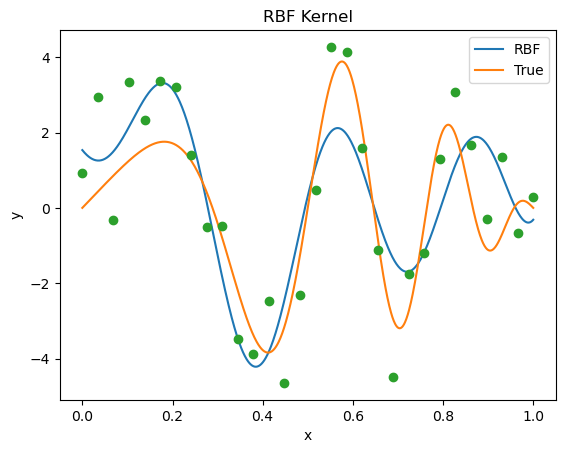

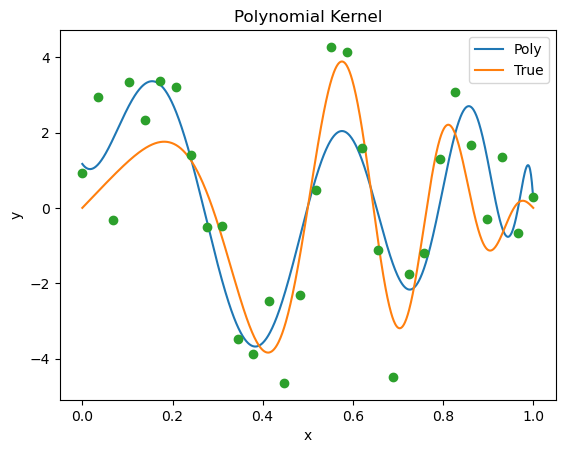

In [13]:
def Q4b():
    # Record the best hyperparameters found in part a)
    rbf_lambda = 0.00011288378916846884
    rbf_gamma = 10.382716049382719
    poly_lambda = 0.00018329807108324357
    poly_d = 23

    # Generate the data
    n = 30
    x = np.linspace(0, 1, n)
    f_x = f_true(x)
    y = f_x + np.random.normal(0, 1, n)
    x_grid = np.linspace(0, 1, 1000) # Define a fine grid on [0, 1]
    y_true = f_true(x_grid)

    # Train and plot the RBF model
    alpha_rbf = train(x, y, rbf_kernel, rbf_gamma, rbf_lambda)
    K_rbf = rbf_kernel(x, x_grid, rbf_gamma)
    y_hat = np.dot(K_rbf.T, alpha_rbf) # Predictions
    plt.plot(x_grid, y_hat, label='RBF')
    plt.plot(x_grid, y_true, label='True')
    plt.plot(x, y, 'o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('RBF Kernel')
    plt.legend()
    plt.show()

    # Train and plot the polynomial model
    alpha_poly = train(x, y, poly_kernel, poly_d, poly_lambda)
    K_poly = poly_kernel(x, x_grid, poly_d)
    y_hat = np.dot(K_poly.T, alpha_poly) # Predictions
    plt.plot(x_grid, y_hat, label='Poly')
    plt.plot(x_grid, y_true, label='True')
    plt.plot(x, y, 'o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Polynomial Kernel')
    plt.legend()
    plt.show()

Q4b()

**c.** [5 points] Repeat parts a and b with $n = 300$, but use 10-fold CV instead of leave-one-out for part a.

RBF: Best lambda: 0.06158482110660261, Best gamma: 11.544550619834713
Poly: Best lambda: 0.0004832930238571752, Best d: 10


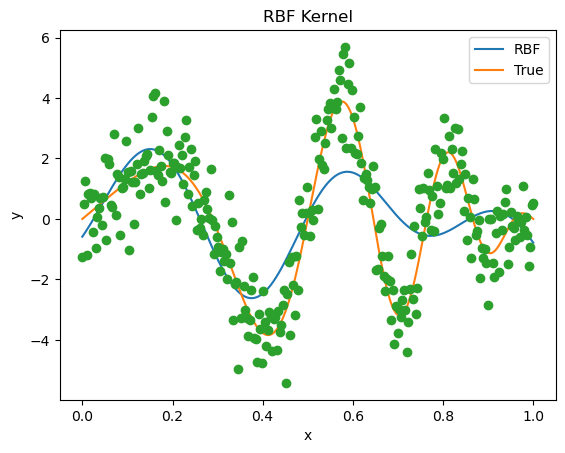

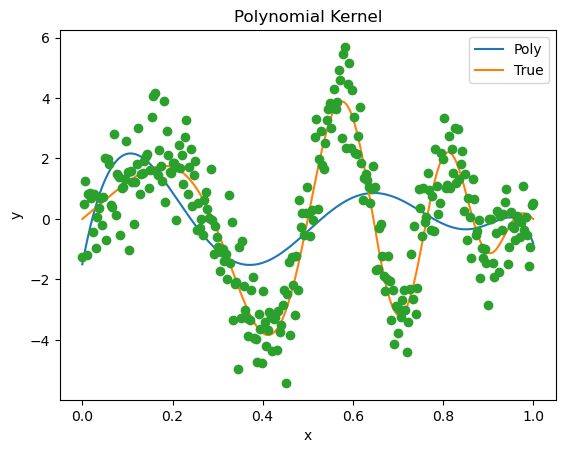

In [14]:
def Q4c():
    # Generate the data
    n = 300 # Repeat the experiment with n = 300
    x = np.linspace(0, 1, n) # Let each xi be drawn uniformly from [0, 1]
    f_x = f_true(x)
    y = f_x + np.random.normal(0, 1, n) # Let yi = f(x) + ei, where ei from Normal(0, 1)

    # Find the best lambda and gamma for the RBF kernel
    rbf_gamma, rbf_lambda = rbf_param_search(x, y, num_folds=10) # Use 10-fold CV instead of LOO
    print(f"RBF: Best lambda: {rbf_lambda}, Best gamma: {rbf_gamma}")

    # Find the best lambda and d for the polynomial kernel
    poly_d, poly_lambda = poly_param_search(x, y, num_folds=10) # Use 10-fold CV instead of LOO
    print(f"Poly: Best lambda: {poly_lambda}, Best d: {poly_d}")

    # Generate the grid and true function values
    x_grid = np.linspace(0, 1, 1000)
    y_true = f_true(x_grid)

    # Train and plot the RBF model
    alpha_rbf = train(x, y, rbf_kernel, rbf_gamma, rbf_lambda)
    K_rbf = rbf_kernel(x, x_grid, rbf_gamma)
    y_hat = np.dot(K_rbf.T, alpha_rbf) # Predictions
    plt.plot(x_grid, y_hat, label='RBF')
    plt.plot(x_grid, y_true, label='True')
    plt.plot(x, y, 'o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('RBF Kernel')
    plt.legend()
    plt.show()

    # Train and plot the polynomial model
    alpha_poly = train(x, y, poly_kernel, poly_d, poly_lambda)
    K_poly = poly_kernel(x, x_grid, poly_d)
    y_hat = np.dot(K_poly.T, alpha_poly) # Predictions
    plt.plot(x_grid, y_hat, label='Poly')
    plt.plot(x_grid, y_true, label='True')
    plt.plot(x, y, 'o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Polynomial Kernel')
    plt.legend()
    plt.show()

Q4c()

**What to Submit:**
- **Part a:** Report the values of $d$, $\gamma$ and the value of $\lambda$ for both kernels as described.
- **Part b:** Two plots. One plot for each function.
- **Part c:** Values of $d$, $\gamma$, and the value of $\lambda$ for both kernels as described. In addition, provide two separate plots as you did for part b.